# Seven Strategies for Optimizing Your Numerical Code

Jupyter notebook that accompanies Jake VanderPlas' PyCon 2018 talk

## K Means: The Algorithm

- Guess some cluster centers
- Repeat until converged
  - assign points to the nearest cluster center
  - set the cluster centers to the mean of assigned points

## Basic Python Implementation

In [3]:
def dist(x, y):
    return sum((xi - yi) ** 2 for xi, yi in zip(x, y))


def find_labels(points, centers):
    labels = []
    for point in points:
        distances = [dist(point, center) for center in centers]
        labels.append(distances.index(min(distances)))
    return labels


def compute_centers(points, labels):
    n_centers = len(set(labels))
    n_dims = len(points[0])
    
    centers = [[0 for i in range(n_dims)] for j in range(n_centers)]
    counts = [0 for j in range(n_centers)]
    
    for label, point in zip(labels, points):
        counts[label] += 1
        centers[label] = [a + b for a, b in zip(centers[label], point)]
        
    return [[x / count for x in center] for center, count in zip(centers, counts)]


def kmeans(points, n_clusters):
    centers = points[-n_clusters:].tolist()
    while True:
        old_centers = centers
        labels = find_labels(points, centers)
        centers = compute_centers(points, labels)
        if centers == old_centers:
            break
    return labels

In [4]:
from sklearn.datasets.samples_generator import make_blobs
points, labels_true = make_blobs(n_samples=5000, centers=4,
                                 random_state=0, cluster_std=0.60)

%timeit kmeans(points, 10)

8.1 s ± 359 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


## Strategy 1: line profiling

In [6]:
%load_ext line_profiler

%lprun -f kmeans kmeans(points, 10)

Timer unit: 1e-06 s

Total time: 13.0948 s
File: <ipython-input-3-0104920df0d9>
Function: kmeans at line 27

Line #      Hits         Time  Per Hit   % Time  Line Contents
    27                                           def kmeans(points, n_clusters):
    28         1         18.0     18.0      0.0      centers = points[-n_clusters:].tolist()
    29         1          1.0      1.0      0.0      while True:
    30        54         68.0      1.3      0.0          old_centers = centers
    31        54   12183973.0 225629.1     93.0          labels = find_labels(points, centers)
    32        54     910588.0  16862.7      7.0          centers = compute_centers(points, labels)
    33        54        177.0      3.3      0.0          if centers == old_centers:
    34         1          1.0      1.0      0.0              break
    35         1          1.0      1.0      0.0      return labels

In [7]:
%lprun -f find_labels kmeans(points, 10)

Timer unit: 1e-06 s

Total time: 13.9076 s
File: <ipython-input-3-0104920df0d9>
Function: find_labels at line 5

Line #      Hits         Time  Per Hit   % Time  Line Contents
     5                                           def find_labels(points, centers):
     6        54        127.0      2.4      0.0      labels = []
     7    270054     224344.0      0.8      1.6      for point in points:
     8    270000   13095690.0     48.5     94.2          distances = [dist(point, center) for center in centers]
     9    270000     587368.0      2.2      4.2          labels.append(distances.index(min(distances)))
    10        54         26.0      0.5      0.0      return labels

## Strategy 2: Numpy Broadcasting

In [9]:
import numpy as np

def find_labels(points, centers):
    diff = (points[:, None, :] - centers)
    distances = (diff ** 2).sum(-1)
    return distances.argmin(1)


def compute_centers(points, labels):
    n_centers = len(set(labels))
    n_dims = len(points[0])
    
    centers = [[0 for i in range(n_dims)] for j in range(n_centers)]
    counts = [0 for j in range(n_centers)]
    
    for label, point in zip(labels, points):
        counts[label] += 1
        centers[label] = [a + b for a, b in zip(centers[label], point)]
        
    return [[x / count for x in center] for center, count in zip(centers, counts)]


def kmeans(points, n_clusters):
    centers = points[-n_clusters:].tolist()
    while True:
        old_centers = centers
        labels = find_labels(points, centers)
        centers = compute_centers(points, labels)
        if centers == old_centers:
            break
    return labels

kmeans(points, 10)[:10]

array([5, 3, 4, 5, 0, 4, 9, 6, 0, 7])

In [10]:
%lprun -f kmeans kmeans(points, 10)

Timer unit: 1e-06 s

Total time: 0.944324 s
File: <ipython-input-9-72ba0feed022>
Function: kmeans at line 23

Line #      Hits         Time  Per Hit   % Time  Line Contents
    23                                           def kmeans(points, n_clusters):
    24         1         10.0     10.0      0.0      centers = points[-n_clusters:].tolist()
    25         1          1.0      1.0      0.0      while True:
    26        54         43.0      0.8      0.0          old_centers = centers
    27        54      83624.0   1548.6      8.9          labels = find_labels(points, centers)
    28        54     860548.0  15936.1     91.1          centers = compute_centers(points, labels)
    29        54         97.0      1.8      0.0          if centers == old_centers:
    30         1          0.0      0.0      0.0              break
    31         1          1.0      1.0      0.0      return labels

In [11]:
%lprun -f compute_centers kmeans(points, 10)

Timer unit: 1e-06 s

Total time: 1.2774 s
File: <ipython-input-9-72ba0feed022>
Function: compute_centers at line 9

Line #      Hits         Time  Per Hit   % Time  Line Contents
     9                                           def compute_centers(points, labels):
    10        54      22656.0    419.6      1.8      n_centers = len(set(labels))
    11        54        134.0      2.5      0.0      n_dims = len(points[0])
    12                                               
    13        54        933.0     17.3      0.1      centers = [[0 for i in range(n_dims)] for j in range(n_centers)]
    14        54        173.0      3.2      0.0      counts = [0 for j in range(n_centers)]
    15                                               
    16    270054     313833.0      1.2     24.6      for label, point in zip(labels, points):
    17    270000     294847.0      1.1     23.1          counts[label] += 1
    18    270000     643802.0      2.4     50.4          centers[label] = [a + b for a, 

In [12]:
def find_labels(points, centers):
    '''
    nearest neighbor search
    '''
    diff = (points[:, None, :] - centers)
    distances = (diff ** 2).sum(-1)
    return distances.argmin(1)


def compute_centers(points, labels):
    n_centers = len(set(labels))
    return np.array([points[labels == i].mean(0)
                     for i in range(n_centers)])


def kmeans(points, n_clusters):
    centers = points[-n_clusters:]
    while True:
        old_centers = centers
        labels = find_labels(points, centers)
        centers = compute_centers(points, labels)
        if np.all(centers == old_centers):
            break
    return labels

kmeans(points, 10)[:10]

array([5, 3, 4, 5, 0, 4, 9, 6, 0, 7])

In [13]:
%timeit kmeans(points, 10)

156 ms ± 5.17 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [14]:
%lprun -f kmeans kmeans(points, 10)

Timer unit: 1e-06 s

Total time: 0.167178 s
File: <ipython-input-12-886ddf907159>
Function: kmeans at line 16

Line #      Hits         Time  Per Hit   % Time  Line Contents
    16                                           def kmeans(points, n_clusters):
    17         1          6.0      6.0      0.0      centers = points[-n_clusters:]
    18         1          0.0      0.0      0.0      while True:
    19        54         47.0      0.9      0.0          old_centers = centers
    20        54      97685.0   1809.0     58.4          labels = find_labels(points, centers)
    21        54      68568.0   1269.8     41.0          centers = compute_centers(points, labels)
    22        54        871.0     16.1      0.5          if np.all(centers == old_centers):
    23         1          1.0      1.0      0.0              break
    24         1          0.0      0.0      0.0      return labels

In [11]:
%lprun -f find_labels kmeans(points, 10)

Timer unit: 1e-06 s

Total time: 0.080624 s
File: <ipython-input-8-2c8ab87198e3>
Function: find_labels at line 1

Line #      Hits         Time  Per Hit   % Time  Line Contents
     1                                           def find_labels(points, centers):
     2        54        30596    566.6     37.9      diff = (points[:, None, :] - centers)
     3        54        42071    779.1     52.2      distances = (diff ** 2).sum(-1)
     4        54         7957    147.4      9.9      return distances.argmin(1)

In [12]:
%lprun -f compute_centers kmeans(points, 10)

Timer unit: 1e-06 s

Total time: 0.053757 s
File: <ipython-input-8-2c8ab87198e3>
Function: compute_centers at line 7

Line #      Hits         Time  Per Hit   % Time  Line Contents
     7                                           def compute_centers(points, labels):
     8        54        22118    409.6     41.1      n_centers = len(set(labels))
     9        54          114      2.1      0.2      return np.array([points[labels == i].mean(0)
    10        54        31525    583.8     58.6                       for i in range(n_centers)])

## 3. Special Data Structures

- KD Tree for nearest neighbor searches
- Groupby in pandas

- ``scipy.spatial`` for spatial queries like distances, nearest neighbors, etc.
- ``scipy.sparse`` sparse matrices for 2-dimensional structured data
- ``sparse`` package for N-dimensional structured data
- ``pandas`` for SQL-like grouping & aggregation
- ``scipy.sparse.csgraph`` for graph-like problems (e.g. finding shortest paths)

In [13]:
from scipy.spatial import cKDTree

def find_labels(points, centers):
    distances, labels = cKDTree(centers).query(points, 1)
    return labels

import pandas as pd

def compute_centers(points, labels):
    df = pd.DataFrame(points)
    return df.groupby(labels).mean().values


def kmeans(points, n_clusters):
    centers = points[-n_clusters:]
    while True:
        old_centers = centers
        labels = find_labels(points, centers)
        centers = compute_centers(points, labels)
        if np.all(centers == old_centers):
            break
    return labels

kmeans(points, 10)[:10]

array([5, 3, 4, 5, 0, 4, 9, 6, 0, 7])

In [14]:
%timeit kmeans(points, 10)

224 ms ± 46.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [15]:
%lprun -f kmeans kmeans(points, 10)

Timer unit: 1e-06 s

Total time: 0.246147 s
File: <ipython-input-13-ccf2ed184cbc>
Function: kmeans at line 14

Line #      Hits         Time  Per Hit   % Time  Line Contents
    14                                           def kmeans(points, n_clusters):
    15         1            6      6.0      0.0      centers = points[-n_clusters:]
    16         1            1      1.0      0.0      while True:
    17        54           47      0.9      0.0          old_centers = centers
    18        54       156153   2891.7     63.4          labels = find_labels(points, centers)
    19        54        89187   1651.6     36.2          centers = compute_centers(points, labels)
    20        54          752     13.9      0.3          if np.all(centers == old_centers):
    21         1            0      0.0      0.0              break
    22         1            1      1.0      0.0      return labels

## 4. Cython

In [15]:
%load_ext Cython

In [16]:
def dist(x, y):
    dist = 0
    for i in range(len(x)):
        dist += (x[i] - y[i]) ** 2
    return dist

def find_labels(points, centers):
    labels = []
    for point in points:
        distances = [dist(point, center) for center in centers]
        labels.append(distances.index(min(distances)))
    return labels

In [17]:
centers = points[:10]
%timeit find_labels(points, centers)

120 ms ± 3.06 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [18]:
%%cython
cimport numpy as np

cdef double dist(double[:] x, double[:] y):
    cdef double dist = 0 # specify double precision FPs
    for i in range(len(x)):
        dist += (x[i] - y[i]) ** 2
    return dist

def find_labels(points, centers):
    labels = []
    for point in points:
        distances = [dist(point, center) for center in centers]
        labels.append(distances.index(min(distances)))
    return labels

In [19]:
centers = points[:10]
%timeit find_labels(points, centers)

121 ms ± 8.12 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [20]:
%%cython
cimport numpy as np
import numpy as np

cdef double dist(double[:] x, double[:] y):
    cdef double dist = 0
    for i in range(len(x)):
        dist += (x[i] - y[i]) ** 2
    return dist

def find_labels(double[:, :] points, double[:, :] centers):
    cdef int n_points = points.shape[0]
    cdef int n_centers = centers.shape[0]
    cdef double[:] labels = np.zeros(n_points)
    cdef double distance, nearest_distance
    cdef int nearest_index
    
    for i in range(n_points):
        nearest_distance = np.inf
        for j in range(n_centers):
            distance = dist(points[i], centers[j])
            if distance < nearest_distance:
                nearest_distance = distance
                nearest_index = j
        labels[i] = nearest_index
    return np.asarray(labels)

In [22]:
centers = points[:10]
%timeit find_labels(points, centers)

1.58 ms ± 24.9 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


## 5. Numba : compiles to LLVM bytecode instead of C

In [23]:
def dist(x, y):
    dist = 0
    for i in range(len(x)):
        dist += (x[i] - y[i]) ** 2
    return dist


def find_labels(points, centers):
    labels = []
    min_dist = np.inf
    min_label = 0
    for i in range(len(points)):
        for j in range(len(centers)):
            distance = dist(points[i], centers[j])
            if distance < min_dist:
                min_dist, min_label = distance, j
        labels.append(min_label)
    return labels

In [24]:
centers = points[:10]
%timeit find_labels(points, centers)

109 ms ± 1.88 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [21]:
import numba

# just add decorators
@numba.jit(nopython=True)
def dist(x, y):
    dist = 0
    for i in range(len(x)):
        dist += (x[i] - y[i]) ** 2
    return dist

@numba.jit(nopython=True)
def find_labels(points, centers):
    labels = []
    min_dist = np.inf
    min_label = 0
    for i in range(len(points)):
        for j in range(len(centers)):
            distance = dist(points[i], centers[j])
            if distance < min_dist:
                min_dist, min_label = distance, j
        labels.append(min_label)
    return labels

ModuleNotFoundError: No module named 'numba'

In [26]:
centers = points[:10]
%timeit find_labels(points, centers)

1.38 ms ± 29.3 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


## 6. Dask

In [27]:
from dask import array as da
from dask import dataframe as dd

In [28]:
points_dask = da.from_array(points, chunks=1000)
result = (points_dask ** 2).sum(1)
result.compute()

array([ 5.94673918, 14.00964977, 13.12598814, ..., 64.21143425,
       67.46733724, 51.7011693 ])

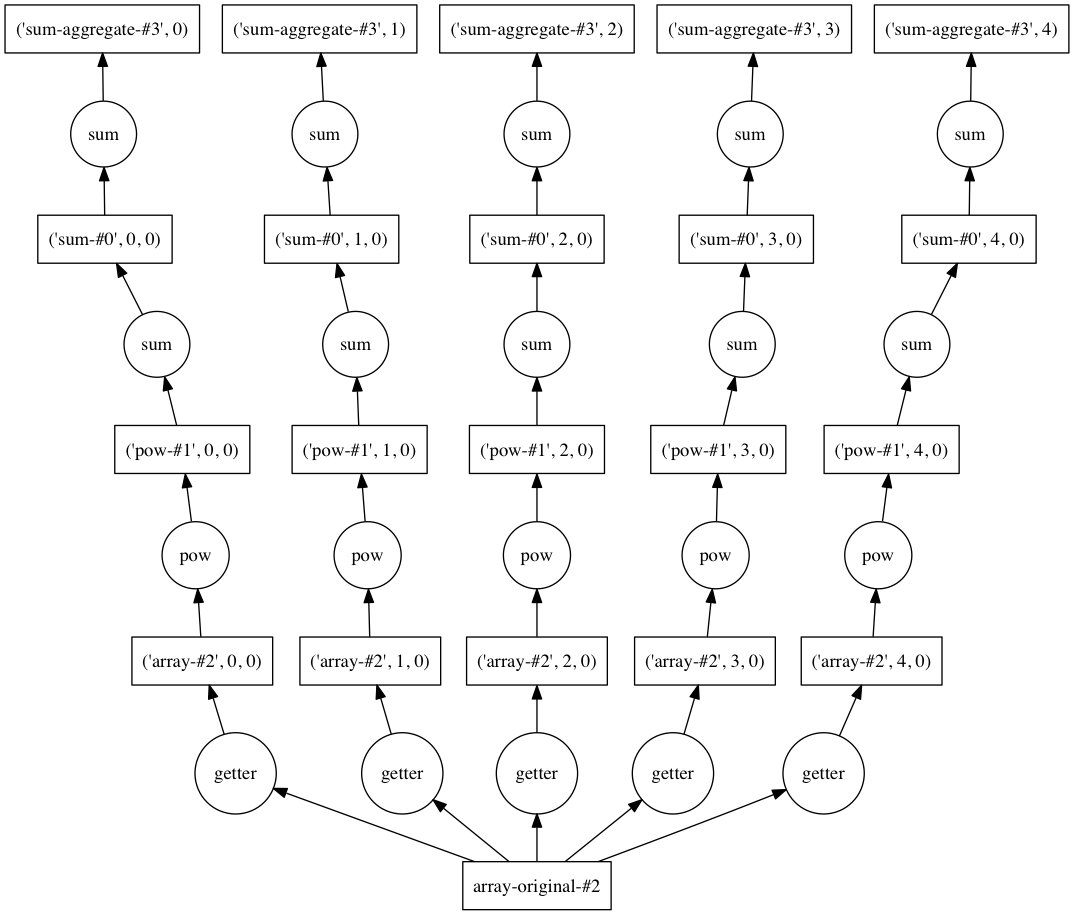

In [29]:
result.visualize()

In [30]:
from dask import array as da

def find_labels(points, centers):
    diff = (points[:, None, :] - centers)
    distances = (diff ** 2).sum(-1)
    return distances.argmin(1)

centers = points[:10]

points_dask = da.from_array(points, chunks=1000)
centers_dask = da.from_array(centers, chunks=5)

labels_dask = find_labels(points_dask, centers_dask)

In [31]:
labels_dask.compute()

array([0, 1, 2, ..., 6, 9, 6])

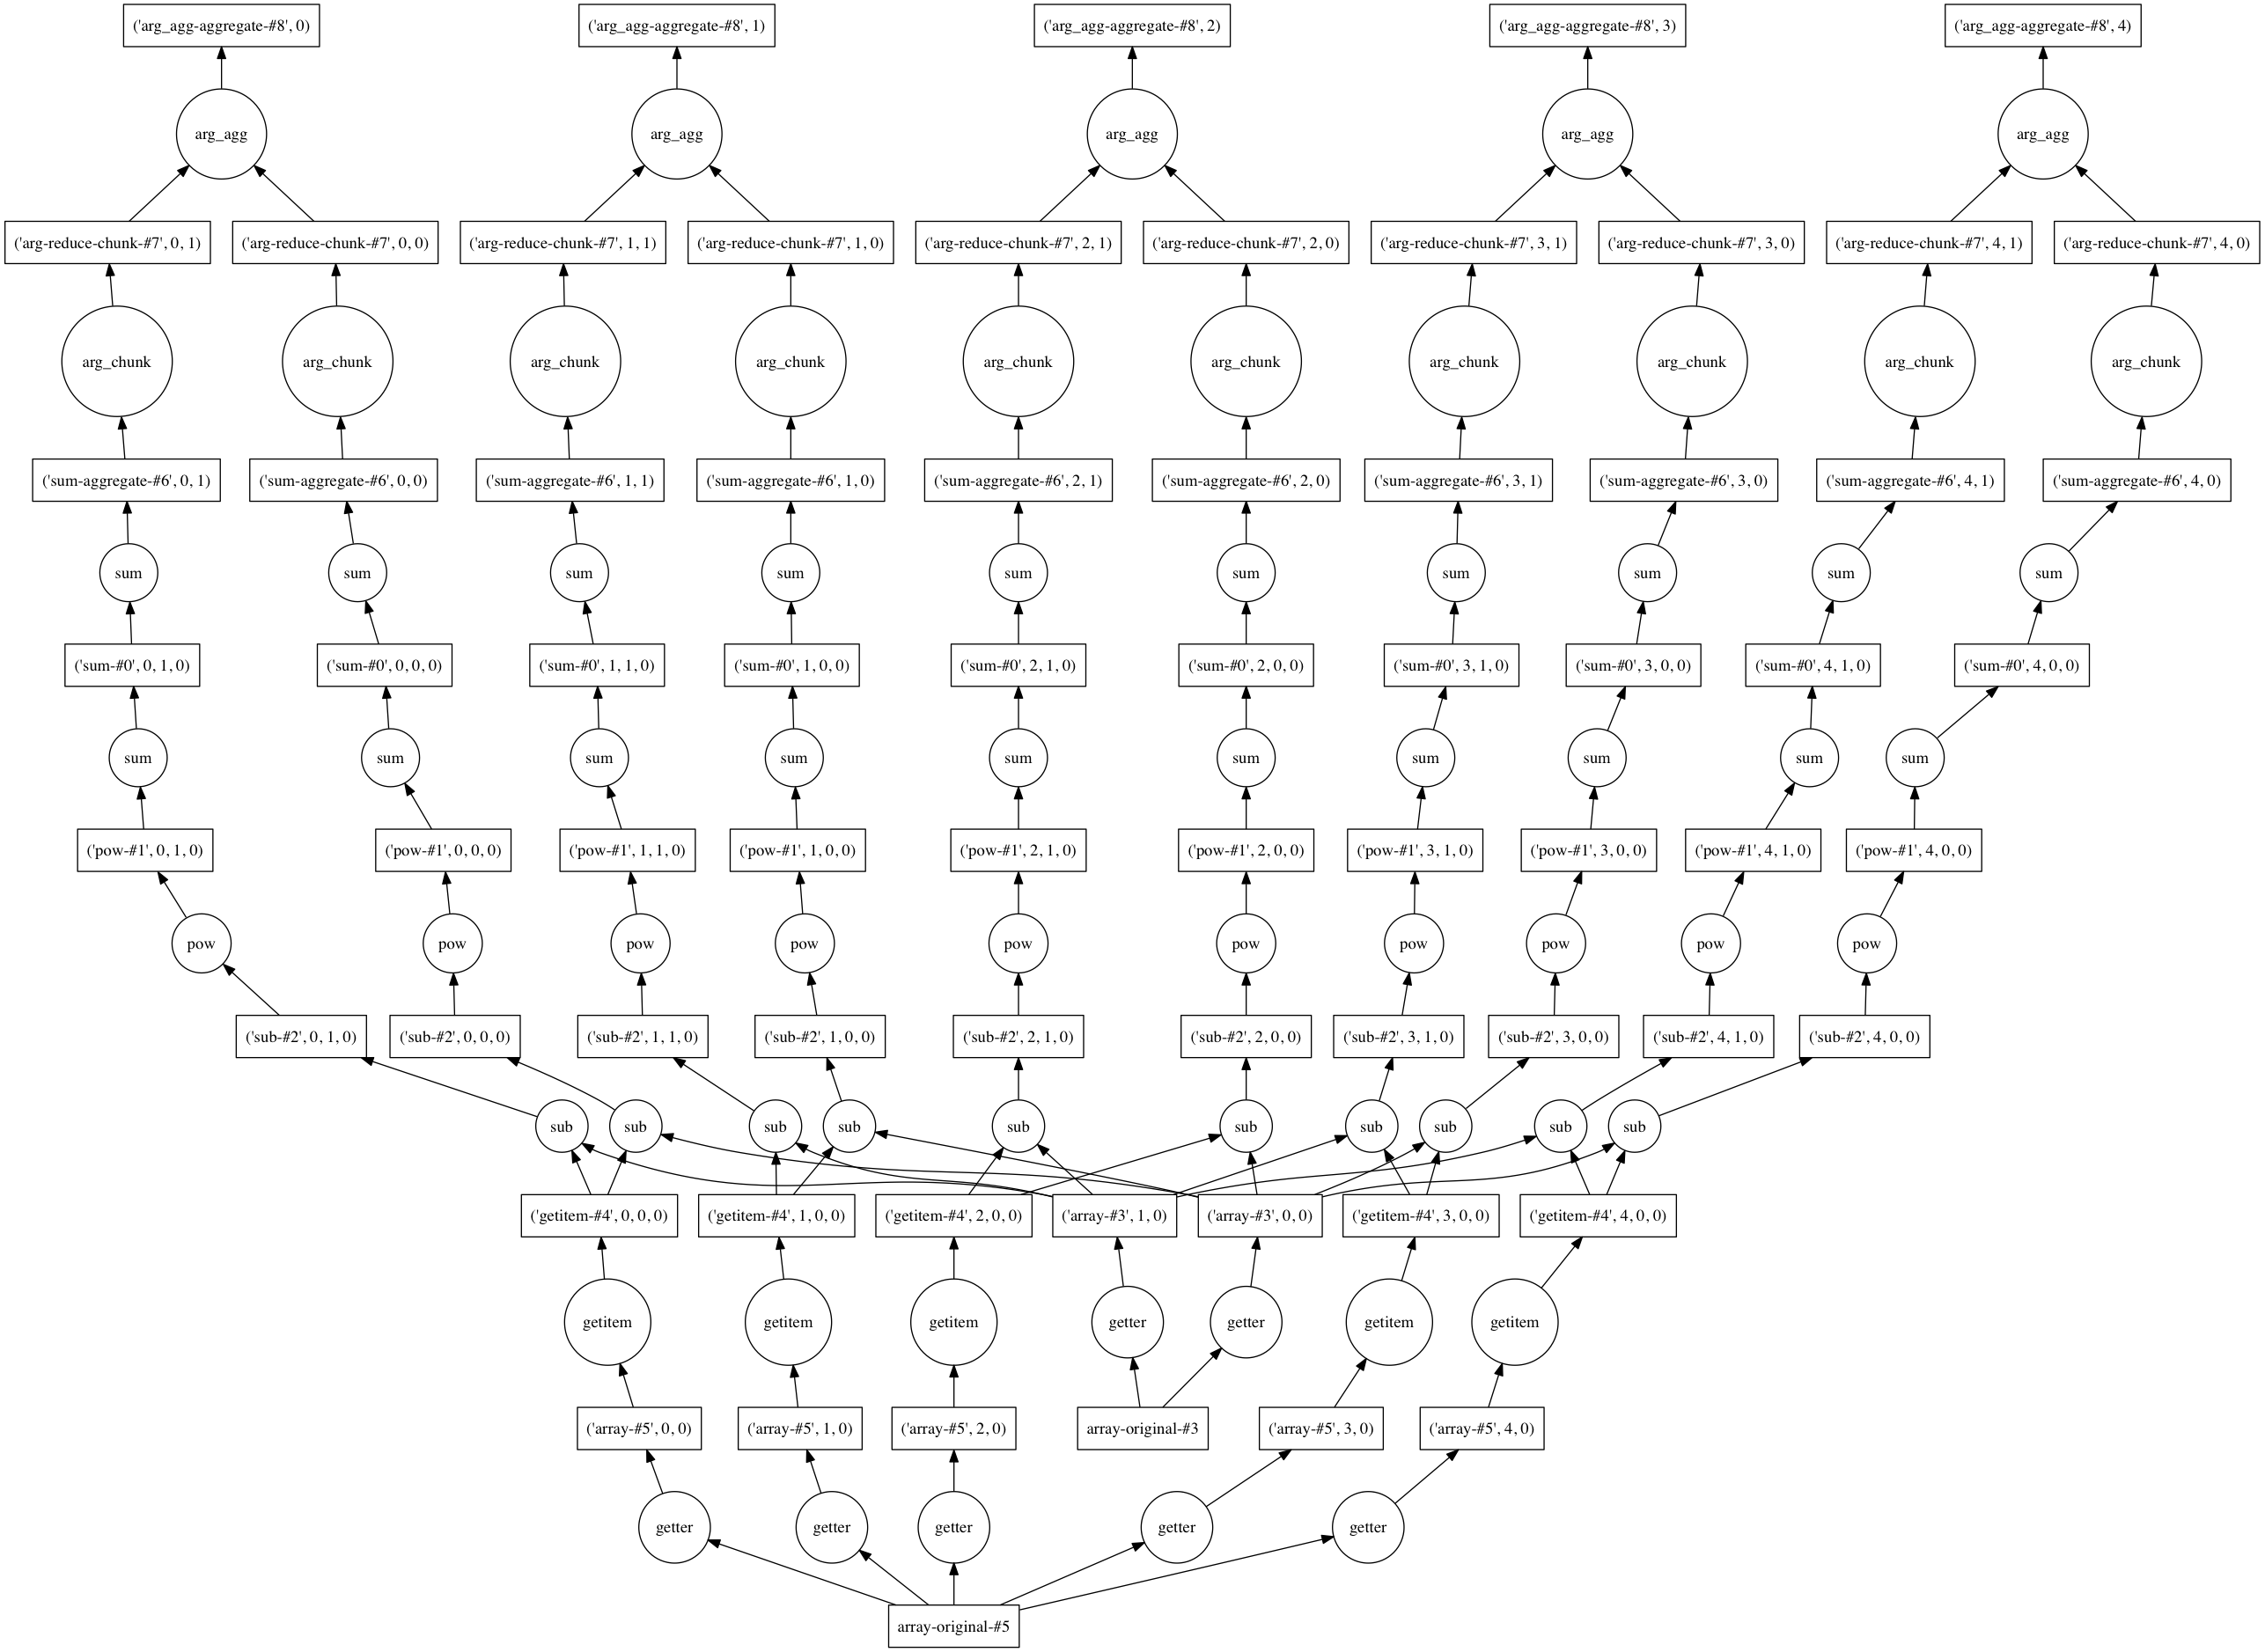

In [32]:
labels_dask.visualize(filename='graph1.png')

In [33]:
from dask import dataframe as dd

def compute_centers(points, labels):
    points_df = dd.from_dask_array(points)
    labels_df = dd.from_dask_array(labels)
    return points_df.groupby(labels_df).mean()

result = compute_centers(points_dask, labels_dask)

In [34]:
result.compute().values

array([[ 2.00922872,  1.03540404],
       [-2.0667431 ,  2.52306223],
       [-0.8672449 ,  3.01911047],
       [ 2.22058825, -0.07949264],
       [ 0.80306779,  4.89056466],
       [-1.70344324,  3.23137327],
       [-1.60575186,  7.32973674],
       [-0.69320682,  7.69520974],
       [ 1.11008872,  3.98520896],
       [-1.41988679,  8.41475127]])

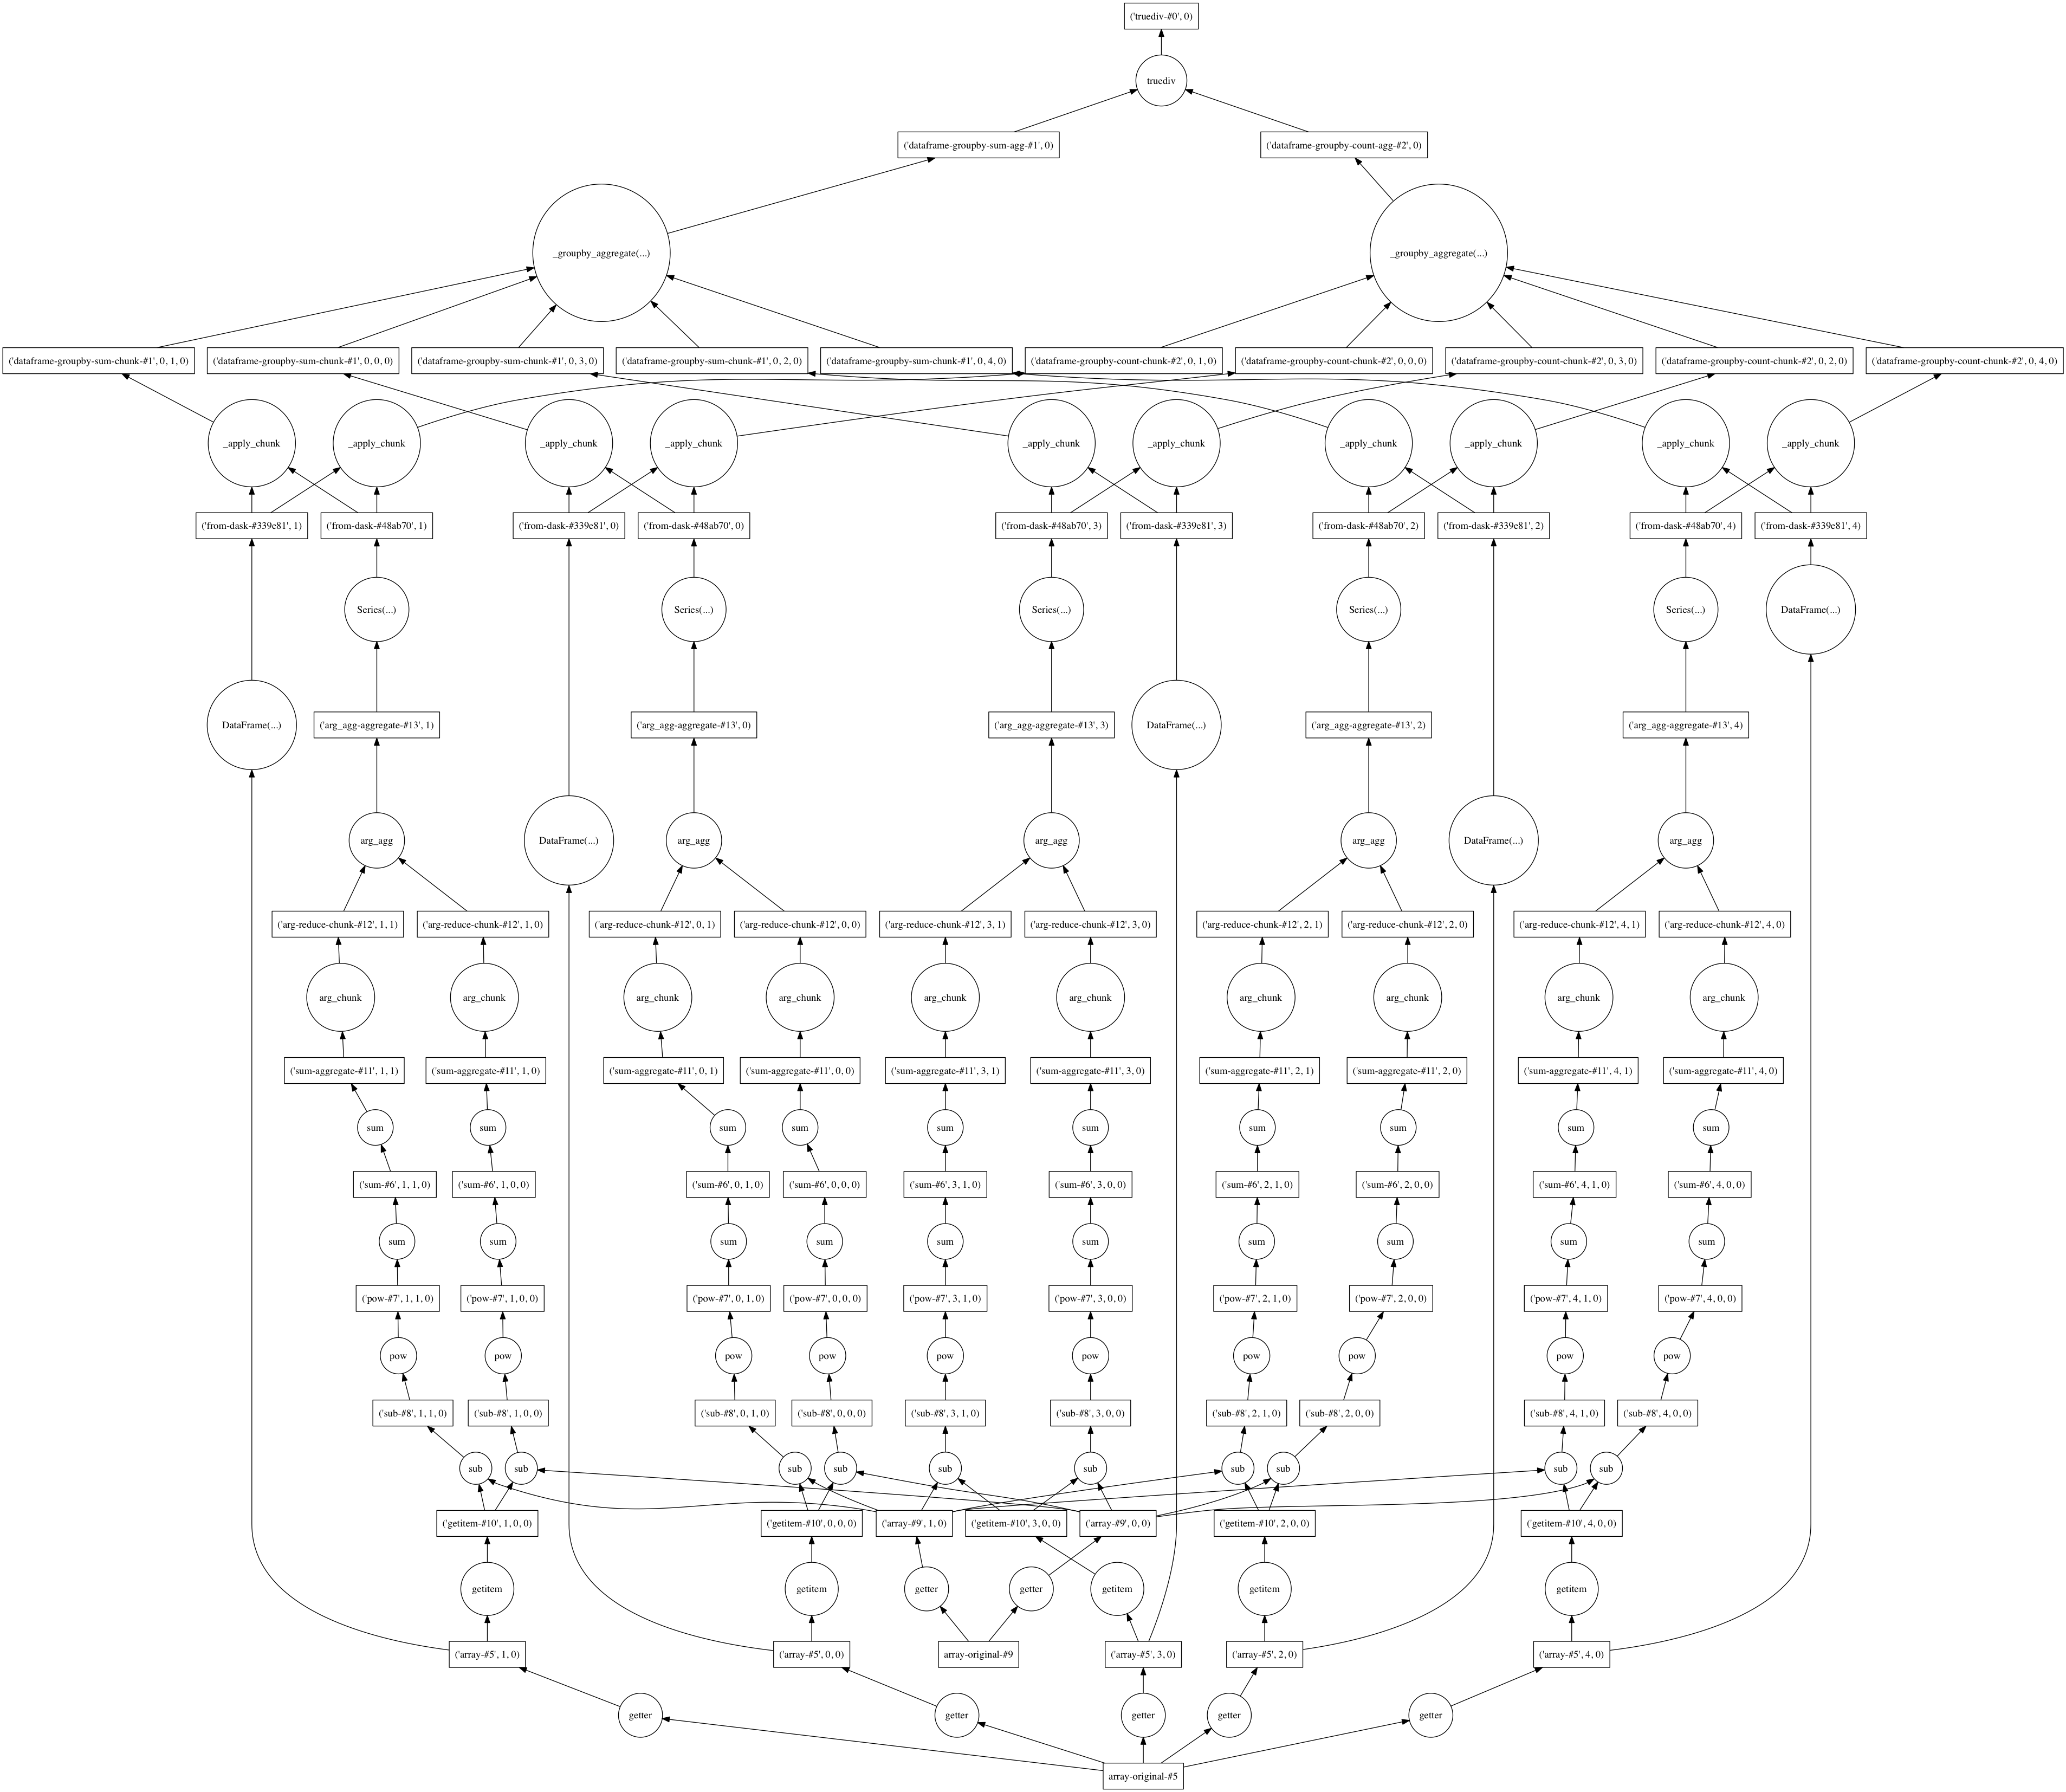

In [35]:
result.visualize()

In [36]:
def find_labels(points, centers):
    diff = (points[:, None, :] - centers)
    distances = (diff ** 2).sum(-1)
    return distances.argmin(1)

def compute_centers(points, labels):
    points_df = dd.from_dask_array(points)
    labels_df = dd.from_dask_array(labels)
    return points_df.groupby(labels_df).mean()

def kmeans(points, n_clusters):
    centers = points[-n_clusters:]
    points = da.from_array(points, 1000)
    while True:
        old_centers = centers
        labels = find_labels(points, da.from_array(centers, 5))
        centers = compute_centers(points, labels)
        centers = centers.compute().values
        if np.all(centers == old_centers):
            break
    return labels.compute()

%timeit kmeans(points, 10)

3.09 s ± 43.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


## 7. Find an existing implementation

For example, scikit-learn's k-means

In [37]:
from sklearn.cluster import KMeans

%timeit KMeans(4).fit_predict(points)

29.2 ms ± 361 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


---

## K Means Algorithm: Animation Frames

In [38]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn')
import warnings
import numpy as np

from ipywidgets import interact
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.datasets.samples_generator import make_blobs


min_clusters = 1
max_clusters = 6

with warnings.catch_warnings():
    warnings.filterwarnings('ignore')

    X, y = make_blobs(n_samples=300, centers=4,
                      random_state=0, cluster_std=0.60)

    def _kmeans_step(frame=0, n_clusters=4):
        rng = np.random.RandomState(2)
        labels = np.zeros(X.shape[0])
        centers = rng.randn(n_clusters, 2)

        nsteps = frame // 3

        for i in range(nsteps + 1):
            old_centers = centers
            if i < nsteps or frame % 3 > 0:
                dist = euclidean_distances(X, centers)
                labels = dist.argmin(1)

            if i < nsteps or frame % 3 > 1:
                centers = np.array([X[labels == j].mean(0)
                                    for j in range(n_clusters)])
                nans = np.isnan(centers)
                centers[nans] = old_centers[nans]


        # plot the data and cluster centers
        plt.scatter(X[:, 0], X[:, 1], c=labels, s=50, cmap='rainbow',
                    vmin=0, vmax=n_clusters - 1);
        plt.scatter(old_centers[:, 0], old_centers[:, 1], marker='o',
                    c=np.arange(n_clusters),
                    s=200, cmap='rainbow')
        plt.scatter(old_centers[:, 0], old_centers[:, 1], marker='o',
                    c='black', s=50)

        # plot new centers if third frame
        if frame % 3 == 2:
            for i in range(n_clusters):
                plt.annotate('', centers[i], old_centers[i], 
                             arrowprops=dict(arrowstyle='->', linewidth=1))
            plt.scatter(centers[:, 0], centers[:, 1], marker='o',
                        c=np.arange(n_clusters),
                        s=200, cmap='rainbow')
            plt.scatter(centers[:, 0], centers[:, 1], marker='o',
                        c='black', s=50)

        plt.xlim(-4, 4)
        plt.ylim(-2, 10)

        if frame % 3 == 1:
            plt.text(3.8, 9.5, "1. Reassign points to nearest centroid",
                     ha='right', va='top', size=14)
        elif frame % 3 == 2:
            plt.text(3.8, 9.5, "2. Update centroids to cluster means",
                     ha='right', va='top', size=14)

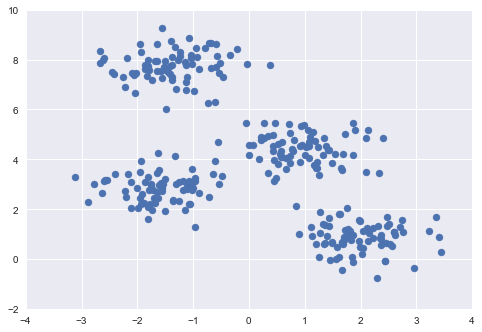

In [39]:
plt.scatter(X[:, 0], X[:, 1], s=50)
plt.xlim(-4, 4)
plt.ylim(-2, 10)
plt.savefig('kmeans-data.png')

In [40]:
# for frame in range(20):
#     fig = plt.figure()
#     _kmeans_frame(i)
#     plt.savefig('kmeans_frame_{0}.png'.format(frame + 1))
#     plt.close(fig)